In [3]:
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import defaultdict, deque

In [4]:
raw_file = "../../plans/raw/workload_100k_s1_c8220.json"
parsed_5k = "../../plans/parsed/workload_5k_s1_c8220.json"
parsed_10k = "../../plans/parsed/workload_10k_s1_c8220.json"

In [5]:
with open(raw_file, "r") as f:
    raw_data = json.load(f)

with open(parsed_5k, "r") as f:
    parsed_5k_plan = json.load(f)

with open(parsed_10k, "r") as f:
    parsed_10k_plan = json.load(f)

In [6]:
import re

planning_time_regex = re.compile('planning time: (?P<planning_time>\d+.\d+) ms')
ex_time_regex = re.compile('execution time: (?P<execution_time>\d+.\d+) ms')
init_plan_regex = re.compile("InitPlan \d+ \(returns \$\d\)")
join_columns_regex = re.compile('\w+\.\w+ ?= ?\w+\.\w+')

In [7]:
#### runtime statistics

## for parsed plan
def runtime_statistics(plans):
  runtime = []
  for i in range(len(plans)):
    runtime.append(plans[i]['plan_runtime'])

  return min(runtime), max(runtime), sum(runtime)/len(runtime), runtime

min_runtime_5k, max_runtime_5k, mean_runtime_5k, run_5k = runtime_statistics(parsed_5k_plan['parsed_plans'])
min_runtime_10k, max_runtime_10k, mean_runtime_10k, run_10k = runtime_statistics(parsed_10k_plan['parsed_plans'])

In [8]:
## for raw plain statement
plain_statement_10k = []
runtime_all = []

count = 0

for i in range(len(raw_data['query_list'])):
  query = raw_data['query_list'][i]
  sql_text = query['sql']
  # print(i, "\n")
  # print(query['analyze_plans'])
  if not query['analyze_plans'] == []:
    runtime_text = query['analyze_plans'][0][-1][0]
    runtime = float(re.search(r'(\d+\.\d+)\s*ms', runtime_text).group(1))
    # print(sql_text, runtime_text)

    if runtime >= 100 and runtime <= 30000:
      data_entry = {"sql": sql_text, "runtime_ms": runtime}
      # runtime_list.append(runtime)
      runtime_all.append(runtime)

      if count < 10000 and runtime == run_10k[count]:
        plain_statement_10k.append(data_entry)
        count += 1
  
# for entry in test_:
#     print(entry)

print(len(plain_statement_10k), len(raw_data['query_list']))

10000 15413


In [9]:
# with open('../../plain_statement_10000.json', 'w') as json_file:
#     json.dump(plain_statement_10k, json_file, indent=4)

In [10]:
print(min_runtime_10k, max_runtime_10k, mean_runtime_10k, len(run_10k))

100.017 29932.898 4308.366410100024 10000


In [11]:
bins = np.linspace(0, 30000, 11)  # 10 bins from 0 to 30000
hist_5k, _ = np.histogram(run_5k, bins=bins)
bin_perc_5k = hist_5k / len(run_5k) * 100
hist_10k, _ = np.histogram(run_10k, bins=bins)
bin_perc_10k = hist_10k / len(run_10k) * 100
hist_all, _ = np.histogram(runtime_all, bins=bins)
bin_perc_all = hist_all / len(runtime_all) * 100

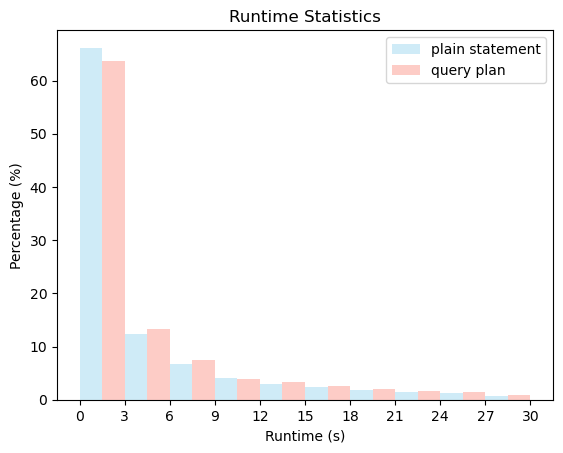

In [12]:
bin_width = bins[1] - bins[0]

# Define x positions for the bars
x_positions1 = bins[:-1]  # Shift left by bin_width/4
x_positions2 = bins[:-1] + bin_width/2  # Shift right by bin_width/4

#### plantime statistics
plt.bar(x_positions1, bin_perc_all, width=bin_width/2, align='edge', alpha=0.4, label='plain statement', color='skyblue')
plt.bar(x_positions2, bin_perc_5k, width=bin_width/2, align='edge', alpha=0.4, label='query plan', color='salmon')
# plt.bar(x_positions2,  bin_perc_10k, width=bin_width/2, align='center', alpha=0.4, label='10k', color='salmon')
plt.title("Runtime Statistics")
plt.xlabel("Runtime (s)")
plt.ylabel("Percentage (%)")  # Include '%' sign
plt.legend()

plt.xticks(bins, [int(x/1000) for x in bins])

plt.show()

In [63]:
#### parsed plans
## op_name count
## aggregation count
## filter_column operator count

op_name_count = defaultdict(int)
aggregation_count = defaultdict(int)
filter_operator_count = defaultdict(int)
plan_levels = []
table_op = defaultdict(int)
max_no_output = 0
max_no_filter = 0
node_output_count= defaultdict(int)
node_output_op = defaultdict(set)
max_count_avg = 0
max_count_sum = 0
max_count_count = 0

fileds = set()

idx = 0

for plan in parsed_10k_plan['parsed_plans']:
  level = 0

  queue = deque([plan])

  while queue:
    level_count = len(queue)
    while level_count > 0:
      level_count -= 1
      node = queue.popleft()
      param = node['plan_parameters']

      for key in param:
        fileds.add(key)

      op_name_count[param['op_name']] += 1

      if 'table' in param:
        table_op[param['op_name']] += 1

      if 'output_columns' in param:
        max_no_output = max(max_no_output, len(param['output_columns']))
        node_output_count[len(param['output_columns'])] += 1
        # if len(param['output_columns']) == 9:
        #   print(param['output_columns'])
        count_sum, count_avg, count_count = 0, 0, 0
        for output in param['output_columns']:
          aggregation_count[output['aggregation']] += 1
          node_output_op[len(param['output_columns'])].add(output['aggregation'])

          if output['aggregation'] == 'SUM':
            count_sum += 1
          elif output['aggregation'] == 'AVG':
            count_avg += 1
          elif output['aggregation'] == 'COUNT':
            count_count += 1
          elif output['aggregation'] != 'None':
            print("Unknown aggregation", output['aggregation'])
        
        max_count_sum = max(max_count_sum, count_sum)
        max_count_avg = max(max_count_avg, count_avg)
        max_count_count = max(max_count_count, count_count)

        # if count_sum == 3:
        #   print(param['output_columns'])
      
      if 'filter_columns' in param:
        op = param['filter_columns']['operator']
        filter_operator_count[op] += 1
        if op == "AND":
          max_no_filter = max(max_no_filter, len(param['filter_columns']['children']))
          # if len(param['filter_columns']['children']) == 5:
          #   print(param['filter_columns']['children'])
          for filters in param['filter_columns']['children']:
            # if filters == "AND":
            #   print("Children in children")
            filter_operator_count[filters['operator']] += 1

      for children in node['children']:
        queue.append(children)

    level += 1

  idx += 1
  plan_levels.append(level)

In [58]:
print(node_output_count)
print(node_output_op)

defaultdict(<class 'int'>, {1: 38197, 2: 36005, 9: 3847, 3: 22856, 4: 11071, 8: 455, 5: 7652, 16: 2545, 7: 2498, 6: 1281})
defaultdict(<class 'set'>, {1: {'AVG', 'SUM', 'COUNT', 'None'}, 2: {'AVG', 'SUM', 'COUNT', 'None'}, 9: {'None'}, 3: {'AVG', 'SUM', 'COUNT', 'None'}, 4: {'None'}, 8: {'None'}, 5: {'None'}, 16: {'None'}, 7: {'None'}, 6: {'None'}})


In [60]:
print(max_count_sum, max_count_avg, max_count_count)

3 3 3


In [34]:
print(op_name_count, '\n', aggregation_count, '\n', filter_operator_count)

defaultdict(<class 'int'>, {'Aggregate': 3374, 'Hash Join': 25970, 'Seq Scan': 29368, 'Hash': 25970, 'Gather': 10042, 'Merge Join': 2036, 'Sort': 4072, 'Materialize': 1793, 'Parallel Seq Scan': 10259, 'Finalize Aggregate': 6626, 'Partial Aggregate': 6626, 'Nested Loop': 1621, 'Gather Merge': 217}) 
 defaultdict(<class 'int'>, {'SUM': 15566, 'None': 320645, 'COUNT': 13569, 'AVG': 15694}) 
 defaultdict(<class 'int'>, {'=': 37244, '>=': 7898, 'AND': 10058, '<=': 7777, '!=': 6890})


In [41]:
print(max_no_filter, max_no_output)

5 16


In [36]:
print(table_op)

defaultdict(<class 'int'>, {'Seq Scan': 29368, 'Parallel Seq Scan': 10259})


In [38]:
print(fileds)

{'table', 'act_startup_cost', 'est_startup_cost', 'act_children_card', 'est_cost', 'est_width', 'filter_columns', 'act_card', 'est_children_card', 'est_card', 'workers_planned', 'act_time', 'output_columns', 'op_name'}


In [27]:
print(len(op_name_count))

13


In [29]:
parsed_5k_plan['parsed_plans'][1293]

{'plain_content': [],
 'plan_parameters': {'op_name': 'Aggregate',
  'est_startup_cost': 42268.64,
  'est_cost': 42268.65,
  'est_card': 1.0,
  'est_width': 8.0,
  'act_startup_cost': 133.386,
  'act_time': 144.088,
  'act_card': 1.0,
  'output_columns': [{'aggregation': 'COUNT', 'columns': []}],
  'act_children_card': 10.0,
  'est_children_card': 11.0,
  'workers_planned': 0},
 'children': [{'plain_content': [],
   'plan_parameters': {'op_name': 'Hash Join',
    'est_startup_cost': 6648.28,
    'est_cost': 42268.62,
    'est_card': 11.0,
    'est_width': 0.0,
    'act_startup_cost': 19.572,
    'act_time': 144.074,
    'act_card': 10.0,
    'filter_columns': {'column': 37,
     'operator': '=',
     'literal': 'customer.c_custkey  ',
     'literal_feature': 0,
     'children': []},
    'act_children_card': 1733745.0,
    'est_children_card': 1618864.0,
    'workers_planned': 0},
   'children': [{'plain_content': [],
     'plan_parameters': {'op_name': 'Gather',
      'est_startup_cost

In [30]:
root = parsed_5k_plan['parsed_plans'][1293]
level = 0

queue = deque([root])

while queue:
  level_count = len(queue)
  print("\n")
  print("Level", level)
  while level_count > 0:
    level_count -= 1
    node = queue.popleft()
    print(node['plan_parameters'])

    for children in node['children']:
      queue.append(children)

  level += 1




Level 0
{'op_name': 'Aggregate', 'est_startup_cost': 42268.64, 'est_cost': 42268.65, 'est_card': 1.0, 'est_width': 8.0, 'act_startup_cost': 133.386, 'act_time': 144.088, 'act_card': 1.0, 'output_columns': [{'aggregation': 'COUNT', 'columns': []}], 'act_children_card': 10.0, 'est_children_card': 11.0, 'workers_planned': 0}


Level 1
{'op_name': 'Hash Join', 'est_startup_cost': 6648.28, 'est_cost': 42268.62, 'est_card': 11.0, 'est_width': 0.0, 'act_startup_cost': 19.572, 'act_time': 144.074, 'act_card': 10.0, 'filter_columns': {'column': 37, 'operator': '=', 'literal': 'customer.c_custkey  ', 'literal_feature': 0, 'children': []}, 'act_children_card': 1733745.0, 'est_children_card': 1618864.0, 'workers_planned': 0}


Level 2
{'op_name': 'Gather', 'est_startup_cost': 1000.0, 'est_cost': 36614.8, 'est_card': 1448.0, 'est_width': 4.0, 'act_startup_cost': 0.36, 'act_time': 127.203, 'act_card': 1569.0, 'workers_planned': 0, 'output_columns': [{'aggregation': 'None', 'columns': [37]}], 'act_